In [1]:
import os
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
import numpy as np
import copy 
from functools import partial
import math
import matplotlib.pyplot as plt
import imblearn.ensemble as ensemble
import sklearn.tree as tree
import sklearn.svm as svm

class RegrGuessAvg:
    def __init__(self):
        self.avg = None

    def fit(self,_,y):
        self.avg = np.mean(y)
    
    def predict(self, _):
        return self.avg
    
class ClassificationRandomGuess:
    def __init__(self):
        self.y = None

    def fit(self,_,y):
        self.y = y
    
    def predict(self, X):
        return np.random.choice(self.y,size=X.shape[0])
    
class VoteReject:
    def __init__(self):
        pass

    def fit(self,_,__):
        pass
    
    def predict(self, _):
        return 0
    
class VoteAccept:
    def __init__(self):
        pass
    
    def fit(self,_,__):
        pass
    
    def predict(self, _):
        return 1

In [2]:

iclr = pd.read_csv("../feature_extraction/iclr.csv")
neurips = pd.read_csv("../feature_extraction/neurips.csv")


In [3]:
def normalize(train, test):
    mean = np.mean(train,axis=0)
    std = np.std(train,axis=0)

    return (train-mean)/std,(test-mean)/std

def norm(x,y):
    return np.mean((np.asarray(x)-np.asarray(y))**2)

def acc(x,y):
    return np.mean((np.asarray(x) == np.asarray(y)).astype(np.int32))



def train_and_stats(model, X_train, X_test, y_train, y_test, stats_fns):
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    stats = []
    for stats_fn in stats_fns:
        stats.append(stats_fn(y_pred,y_test))

    return stats

In [4]:
def split_dataset(df, num_splits = 10):
    len_dataset = len(df)
    df_deepcopy = copy.deepcopy(df)
    dfs = []
    for _ in range(1,num_splits+1):
        dfs.append(df_deepcopy[:int(len_dataset/num_splits)])
        df_deepcopy = df_deepcopy[int(len_dataset/num_splits):]
    
    train_test_splits = []
    for i in range(len(dfs)):
        test_split = copy.deepcopy(dfs[i])
        train_split = []
        for j in range(len(dfs)):
            if j != i:
                train_split.append(copy.deepcopy(dfs[j]))
        train_split = pd.concat(train_split)

        train_test_splits.append((train_split,test_split))
    return train_test_splits

def prepare_dataset(df_train,df_test,y_map_fn,X_map_fn):

    X_train = X_map_fn(df_train)
    y_train = y_map_fn(df_train)

    X_test = X_map_fn(df_test)
    y_test = y_map_fn(df_test)

    X_train,X_test = normalize(X_train, X_test)

    return X_train, X_test, y_train, y_test

def plot(models, df ,y_map_fn, xlabel, ylabel, title, X_map_fn = lambda df : df[["num_equations","mean_num_new_symbols_introduced","num_overall_unique_symbols","mean_num_unique_symbols","std_of_unique_symbols","max_representational_complexity"]],
         sort_reverse=False):

    models_and_stats = copy.deepcopy(models)
    for name,model in models_and_stats.items():
        models_and_stats[name] = (model,[])    

    for model,stats_list in models_and_stats.values():
        train_test_splits = split_dataset(df)
        train_test_splits = [prepare_dataset(*split,y_map_fn=y_map_fn,X_map_fn=X_map_fn) for split in train_test_splits]
        
        for X_train, X_test, y_train, y_test in train_test_splits:
            stats = train_and_stats(model(),X_train, X_test, y_train, y_test, [norm])
            stats_list.append(stats)

   
    models_and_stats = {key: value for key, value in sorted(models_and_stats.items(), reverse=sort_reverse,key=lambda e: np.mean(e[1][1]))}

    for name,(model,stats_list) in models_and_stats.items():
        plt.bar(name,np.mean(stats_list),color = "blue")

    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation=75)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.show()

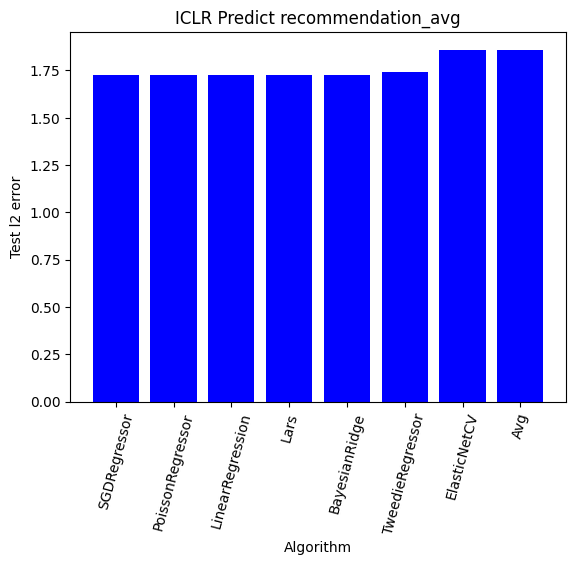

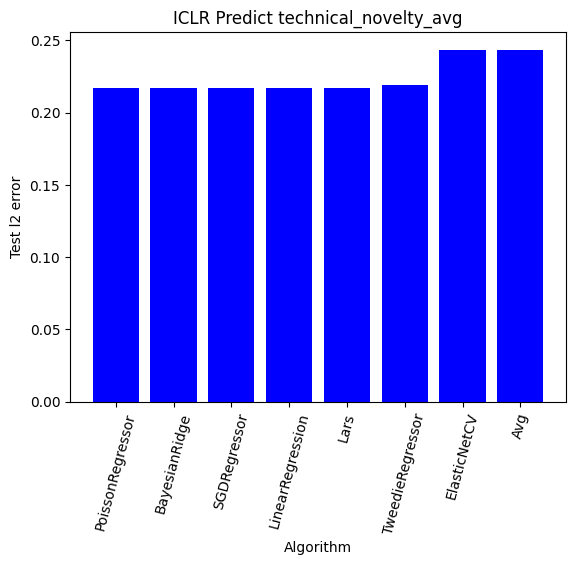

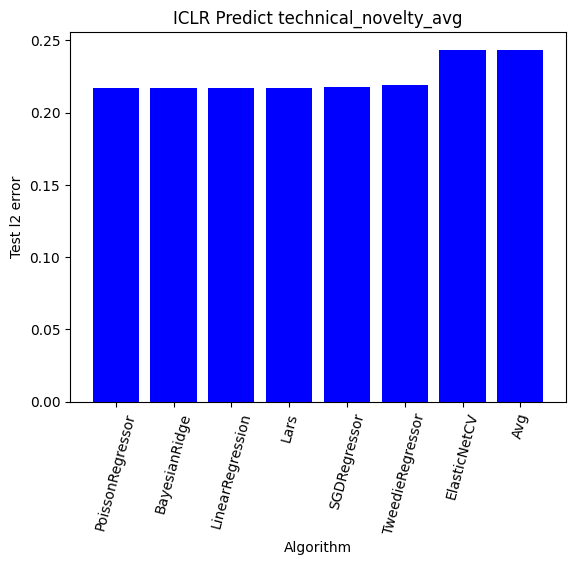

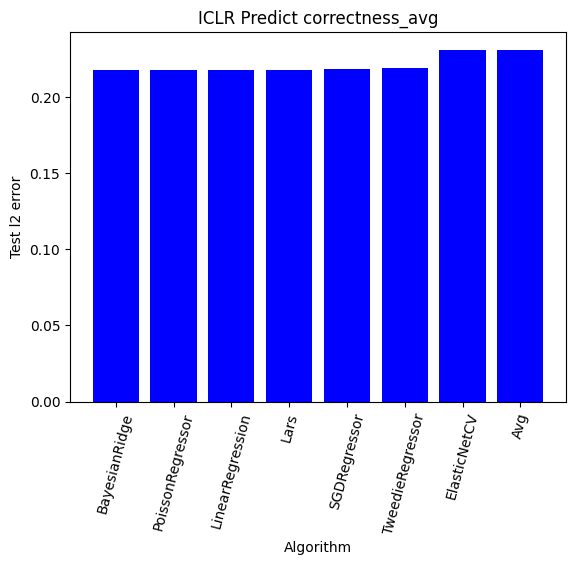

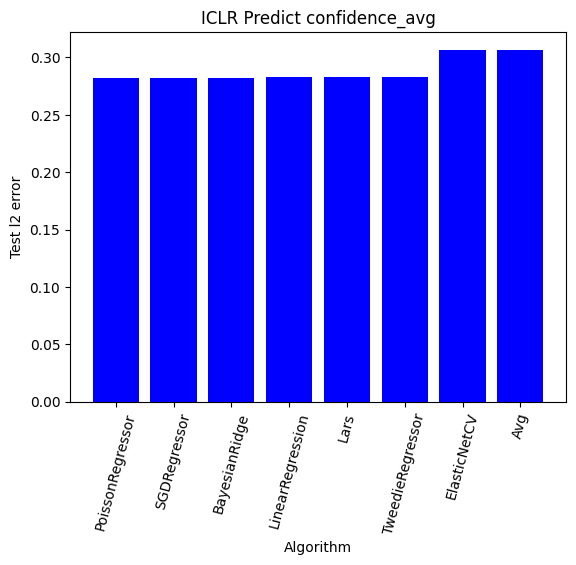

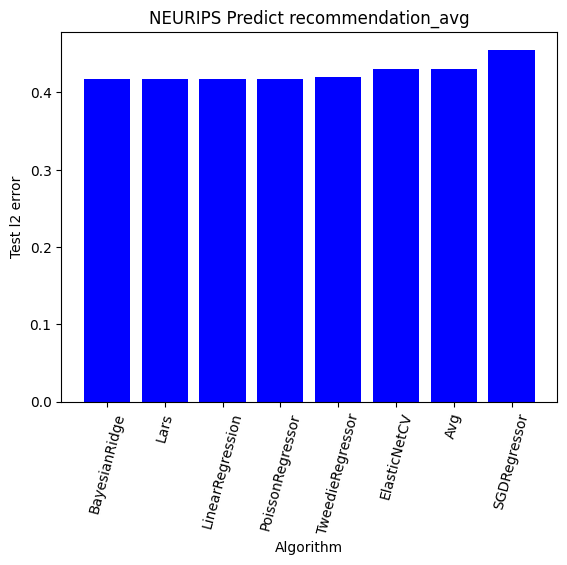

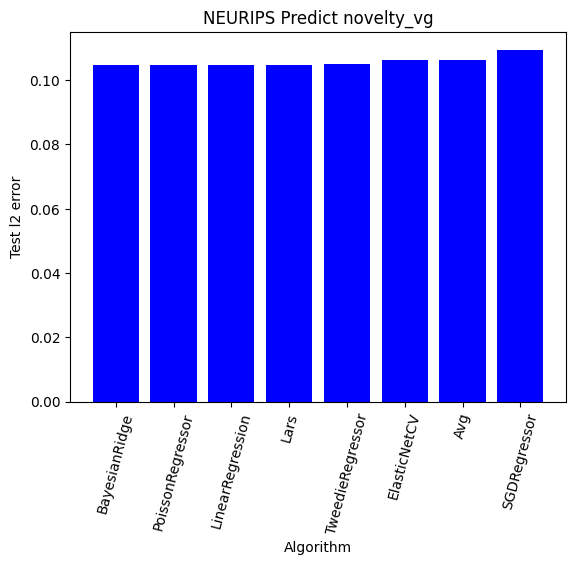

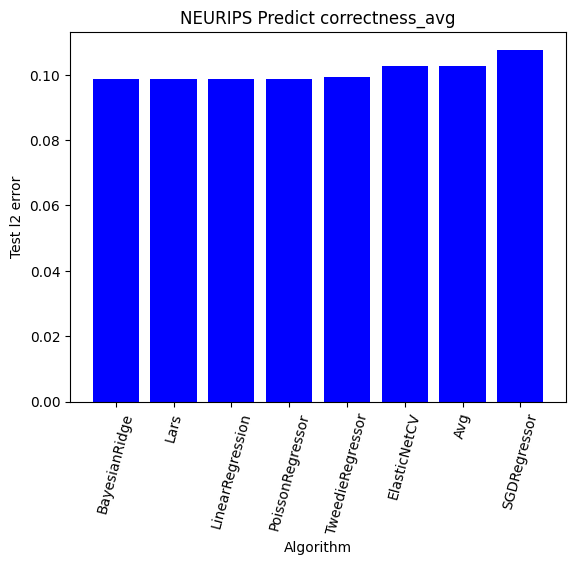

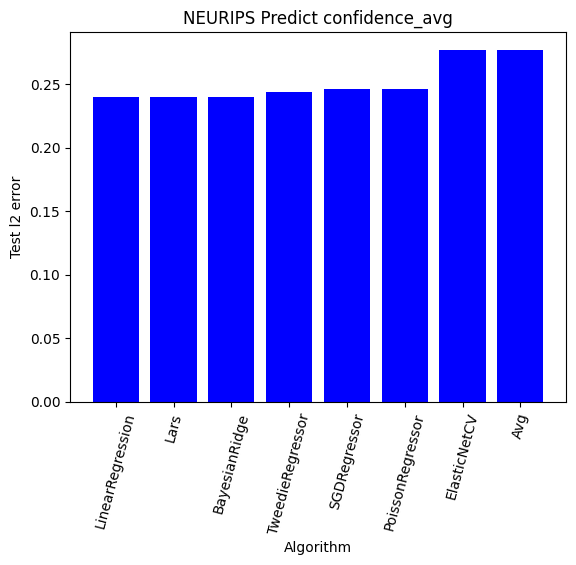

In [5]:
models = {"LinearRegression" : partial(lm.LinearRegression),
          "SGDRegressor" : partial(lm.SGDRegressor), 
          "ElasticNetCV" : partial(lm.ElasticNet), 
          "Lars" : partial(lm.Lars), 
          "BayesianRidge" : partial(lm.BayesianRidge), 
          "PoissonRegressor" : partial(lm.PoissonRegressor), 
          "TweedieRegressor" : partial(lm.TweedieRegressor), 
          "Avg" : partial(RegrGuessAvg)}


plot(models,iclr,y_map_fn=lambda df : df.recommendation_avg,xlabel="Algorithm",ylabel = "Test l2 error",title="ICLR Predict recommendation_avg")
plot(models,iclr,y_map_fn=lambda df : df.technical_novelty_avg,xlabel="Algorithm",ylabel = "Test l2 error",title="ICLR Predict technical_novelty_avg")
plot(models,iclr,y_map_fn=lambda df : df.technical_novelty_avg,xlabel="Algorithm",ylabel = "Test l2 error",title="ICLR Predict technical_novelty_avg")
plot(models,iclr,y_map_fn=lambda df : df.correctness_avg,xlabel="Algorithm",ylabel = "Test l2 error",title="ICLR Predict correctness_avg")
plot(models,iclr,y_map_fn=lambda df : df.confidence_avg,xlabel="Algorithm",ylabel = "Test l2 error",title="ICLR Predict confidence_avg")

plot(models,neurips,y_map_fn=lambda df : df.recommendation_avg,xlabel="Algorithm",ylabel = "Test l2 error",title="NEURIPS Predict recommendation_avg")
plot(models,neurips,y_map_fn=lambda df : df.novelty_avg,xlabel="Algorithm",ylabel = "Test l2 error",title="NEURIPS Predict novelty_vg")
plot(models,neurips,y_map_fn=lambda df : df.correctness_avg,xlabel="Algorithm",ylabel = "Test l2 error",title="NEURIPS Predict correctness_avg")
plot(models,neurips,y_map_fn=lambda df : df.confidence_avg,xlabel="Algorithm",ylabel = "Test l2 error",title="NEURIPS Predict confidence_avg")

In [6]:
def iclr_x_mapfn(df):
    return df[df.status != "Withdraw"][["num_equations","mean_num_new_symbols_introduced","num_overall_unique_symbols","mean_num_unique_symbols","std_of_unique_symbols","max_representational_complexity"]]
def iclr_y_mapfn(df):

    y = df[df.status != "Withdraw"].status
    y = np.asarray(y)
    y[y == "Reject"] = 0
    y[y == "Desk Reject"] = 0
    y[y == "Top-25%"] = 1
    y[y == "Top-5%"] = 1
    y[y == "Poster"] = 1

    
    return y.astype(np.int32)

def neurips_y_mapfn(df):
    y = df.status
    y = np.asarray(y)
    y[y == "Reject"] = 0
    y[y == "Poster"] = 1
    y[y == "Spotlight"] = 1
    y[y == "Oral"] = 1

    return y.astype(np.int32)

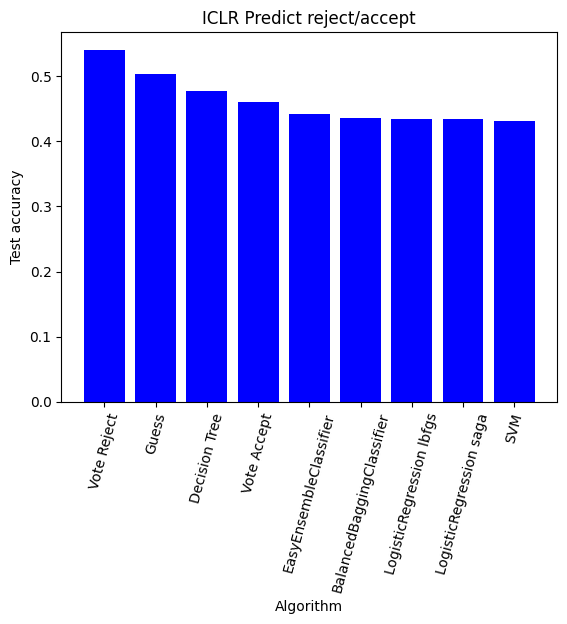

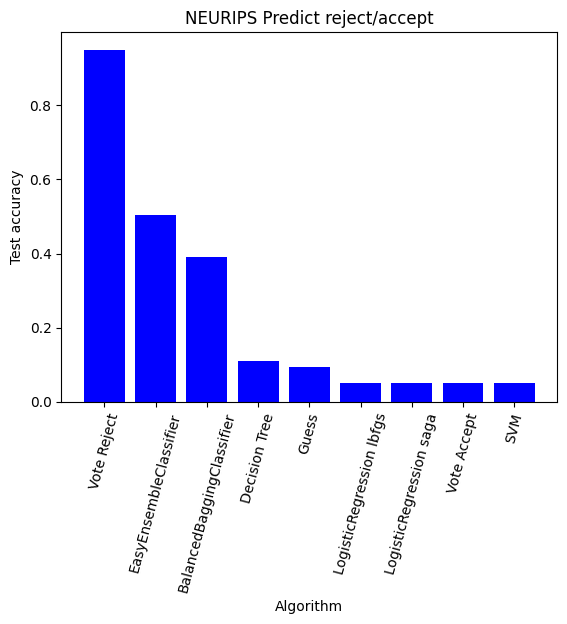

In [7]:
models = {"LogisticRegression lbfgs" : partial(lm.LogisticRegression,max_iter=50000,solver="lbfgs"),
          "LogisticRegression saga" : partial(lm.LogisticRegression,max_iter=50000,solver="saga"),
          "Guess" : partial(ClassificationRandomGuess), 
          "Vote Reject" : partial(VoteReject), 
          "Vote Accept" : partial(VoteAccept), 
          "Decision Tree" : partial(tree.DecisionTreeClassifier),
          "SVM" : partial(svm.SVC),
          "BalancedBaggingClassifier" : partial(ensemble.BalancedBaggingClassifier),
          "EasyEnsembleClassifier" : partial(ensemble.EasyEnsembleClassifier),
}


plot(models,iclr,y_map_fn=iclr_y_mapfn,X_map_fn=iclr_x_mapfn,xlabel="Algorithm",ylabel = "Test accuracy",title="ICLR Predict reject/accept",sort_reverse=True)
plot(models,neurips,y_map_fn=neurips_y_mapfn,xlabel="Algorithm",ylabel = "Test accuracy",title="NEURIPS Predict reject/accept",sort_reverse=True)